In [2]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [ ]:
import argparse
import logging
import pickle
import random

import torch
import numpy as np

import tvm
from tvm.auto_scheduler.utils import to_str_round
from tvm.auto_scheduler.cost_model import RandomModelInternal

sys.path.append("/root/work/tenset/scripts")
from common import load_and_register_tasks, str2bool
from train_model import train_zero_shot

from tvm.auto_scheduler.dataset import Dataset, LearningTask
from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
from tvm.auto_scheduler.cost_model.mlp_model import MLPModelInternal
from tvm.auto_scheduler.cost_model.lgbm_model import LGBModelInternal
from tvm.auto_scheduler.cost_model.tabnet_model import TabNetModelInternal
from tvm.auto_scheduler.cost_model.metric import (
    metric_rmse,
    metric_r_squared,
    metric_pairwise_comp_accuracy,
    metric_top_k_recall,
    metric_peak_score,
    metric_mape,
    random_mix,
)

# load_and_register_tasks()
# dataset_k80 = pickle.load(open("../../dataset.pkl", "rb"))
# dataset_t4 = pickle.load(open("../../dataset_t4.pkl", "rb"))
# train_set, test_set = dataset.random_split_within_task(0.9)

# tenset_model = MLPModelInternal()
# tenset_model.fit_base(train_set, valid_set=test_set)

In [11]:
import sys
sys.path.append("/root/work/tenset/scripts")

from tvm import auto_scheduler
from print_programs import return_program
from tvm.auto_scheduler.feature import get_per_store_features_from_file
from make_dataset import load_and_register_tasks
import numpy as np

k80_json_file = "/root/work/tenset/dataset/measure_records_tenset/k80/([0bcb8746286db050cd088f375c85372d,1,64,64,128,6,6,32,128,1,64,64,32],cuda).json"
t4_json_file = "/root/work/tenset/dataset/measure_records_tenset/t4/([0bcb8746286db050cd088f375c85372d,1,64,64,128,6,6,32,128,1,64,64,32],cuda).json"
local_json_file = "/root/work/tenset/dataset/measure_records_tenset/unknown/([0bcb8746286db050cd088f375c85372d,1,64,64,128,6,6,32,128,1,64,64,32],cuda).json"

tasks = load_and_register_tasks()
tasks = load_and_register_tasks("/root/work/tenset/dataset/network_info")
# inputs, results = auto_scheduler.RecordReader(k80_json_file).read_lines()

In [22]:
# inputs, results = auto_scheduler.RecordReader(k80_json_file).read_lines()
raw_features_k80, raw_throughputs_k80, task_ids, min_latency = get_per_store_features_from_file(k80_json_file, 10000)
raw_features_t4, raw_throughputs_t4, task_ids, min_latency = get_per_store_features_from_file(t4_json_file, 10000)
raw_features_local, raw_throughputs_local, task_ids, min_latency = get_per_store_features_from_file(local_json_file, 10000)

features_k80 = []
features_t4 = []
features_local = []

throughputs_k80 = []
throughputs_t4 = []
throughputs_local = []

for i, (k80, t4, local) in enumerate(zip(raw_throughputs_k80, raw_throughputs_t4, raw_throughputs_local)):
    if k80 > 1e-10 and t4 > 1e-10 and local > 1e-10:
        features_k80.append(raw_features_k80[i])
        features_t4.append(raw_features_t4[i])
        features_local.append(raw_features_local[i])
        throughputs_k80.append(k80)
        throughputs_t4.append(t4)
        throughputs_local.append(local)

In [23]:
features_k80 = np.array(features_k80)
features_t4 = np.array(features_t4)
features_local = np.array(features_local)

In [46]:
for i, (k80, t4, local) in enumerate(zip(features_k80, features_t4, features_local)):
    if np.array_equal(k80, t4):
        print("same", i)
        print(throughputs_k80[i], throughputs_t4[i])

same 9
0.12213747203350067 0.24212788045406342
same 26
0.21302732825279236 0.35660284757614136
same 34
0.9309326410293579 0.7086067199707031
same 86
0.1970985382795334 0.36239945888519287
same 97
0.23966652154922485 0.38317006826400757
same 107
0.24267935752868652 0.37183353304862976
same 130
0.20335230231285095 0.26834991574287415
same 139
0.29393285512924194 0.31733644008636475
same 189
0.253070205450058 0.3322679102420807
same 199
0.10643141716718674 0.162167027592659
same 201
0.8198854923248291 0.6169834733009338
same 214
0.4899360239505768 0.5770828127861023
same 261
0.16887392103672028 0.3558846414089203
same 263
0.034157220274209976 0.058441951870918274
same 265
0.29580065608024597 0.5220879316329956
same 330
0.45999881625175476 0.3217540383338928
same 340
0.00639404496178031 0.005010765511542559
same 346
0.02450648695230484 0.042237889021635056
same 370
0.0519096739590168 0.14984528720378876
same 394
0.5796486735343933 0.49642741680145264
same 410
0.21255704760551453 0.35532087

In [ ]:
# raw_throughputs_k80 = list(dataset_k80.throughputs.values())[0]
# raw_throughputs_t4 = list(dataset_t4.throughputs.values())[0]
# raw_throughputs_local = list(dataset_local.throughputs.values())[0]


# throughputs_k80 = []
# throughputs_t4 = []
# throughputs_local = []
# for k80, t4, local in zip(raw_throughputs_k80, raw_throughputs_t4, raw_throughputs_local):
#     if k80 > 1e-10 and t4 > 1e-10 :  # segment 길이가 1이 아닌 것만
#         throughputs_k80.append(k80)
#         throughputs_t4.append(t4)

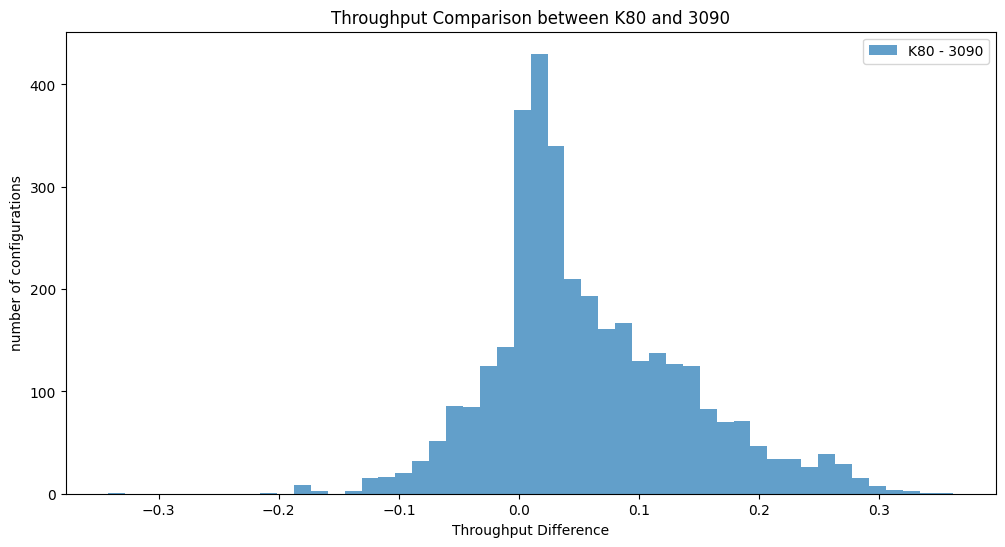

In [47]:
# throughputs_k80, throughputs_t4 점 그래프 그리기
# x축은 인덱스, y축은 throughput
import numpy as np
throughputs_k80 = np.array(throughputs_k80)
throughputs_t4 = np.array(throughputs_t4)
throughputs_local = np.array(throughputs_local)

sub = throughputs_t4 - throughputs_local

# 0.05 이상인 sub 남기기
# sub = sub[np.abs(sub) > 0.1]
# throughputs_k80 = throughputs_k80[np.abs(sub) > 0.05]
# throughputs_t4 = throughputs_t4[np.abs(sub) > 0.05]



import matplotlib.pyplot as plt
# 조금 더 크게
plt.figure(figsize=(12, 6))
# plt.scatter(range(len(sub)), sub, label='K80')
# 히스토그램
plt.hist(sub, bins=50, alpha=0.7, label='K80 - 3090')
# plt.scatter(range(len(throughputs_t4)), throughputs_t4, label='T4')
plt.xlabel('Throughput Difference')
plt.ylabel('number of configurations')
plt.title('Throughput Comparison between K80 and 3090')
plt.legend()
plt.show()